In [188]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker

sys.path.append(str(Path.cwd()))

from plotting_constants import coarse_regions, colors
idx = pd.IndexSlice

In [255]:
root = str(Path.cwd().parent.parent.parent / "cluster_data" / "{}_data")

app = "dh"

color = colors[app]

In [256]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def get_cm(color, factor=2., name="itsacminnit", show=False, asymetric=False):
    """returns colormap between darker and lighter version passed color"""

    if not asymetric:
        colors = [adjust_lightness(color, amount=factor), adjust_lightness(color, amount=1/factor)]
    else:
        colors = [adjust_lightness(color, amount=factor), color]

    cm = LinearSegmentedColormap.from_list(
            name, colors, N=20)

    if show:
        plt.imshow(np.indices((10,10))[1], cmap=cm)
        plt.show()

    return cm

In [257]:
header = [4,5,6,7,8]

df = pd.read_csv(
    Path(root.format(app)) /
    "nodal_geothermal_stats.csv", 
    index_col=[0,1], 
    header=header,
    ).sort_index()

In [258]:
df.index.get_level_values(1).unique()

Index(['dac', 'geothermal generation share', 'geothermal heat dh',
       'offwind-ac', 'onwind', 'solar', 'offwind-dc'],
      dtype='object')

In [259]:
totals = df.loc[idx[:,"geothermal generation share"], idx[:,:,"static",:,:]]
totals.index = totals.index.droplevel(1)

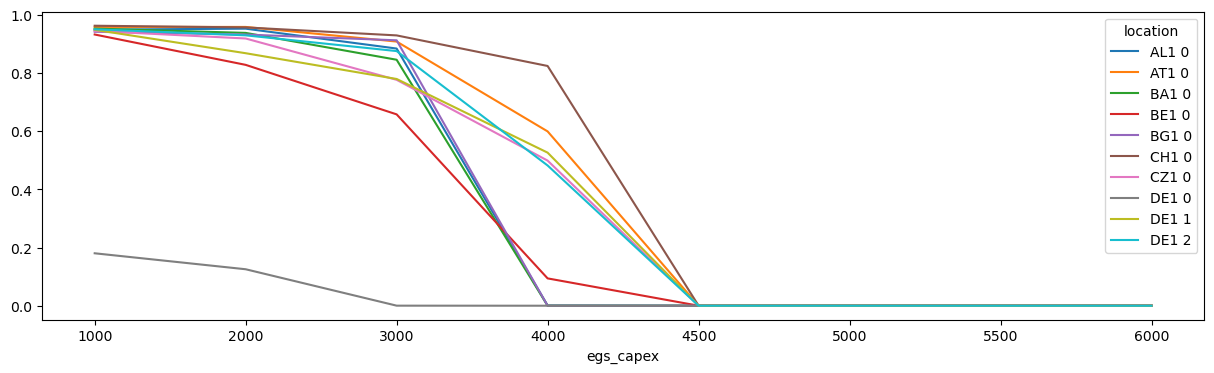

In [260]:
this = df.loc[idx[totals.index[:10], "geothermal generation share"], idx[:,:,"static",:,:]]
this.columns = this.columns.get_level_values(0)
this.index = this.index.get_level_values(0)

fig, ax = plt.subplots(1, 1, figsize=(15,4))
this.T.plot(ax=ax)

plt.show()

In [261]:
from itertools import product

this = df.loc[idx[:, "geothermal generation share"], idx[:,:,"static",:,:]]

this.columns = this.columns.get_level_values(0)
this.index = this.index.get_level_values(0)

xp = this.columns.to_numpy().astype(float)
x = np.linspace(xp[0], xp[-1], 1000)

data = pd.DataFrame(index=this.index.unique(), columns=[0.1, 0.2, 0.3])

for bus, thresh in product(data.index, data.columns):

    yp = this.loc[bus].values.astype(float)

    y = np.interp(x, xp, yp)
    data.loc[bus, thresh] = x[len(y[y > thresh])]

C:\Users\lukas\AppData\Local\Temp\ipykernel_22912\1047059466.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\lukas\AppData\Local\Temp\ipykernel_22912\1047059466.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5500"])


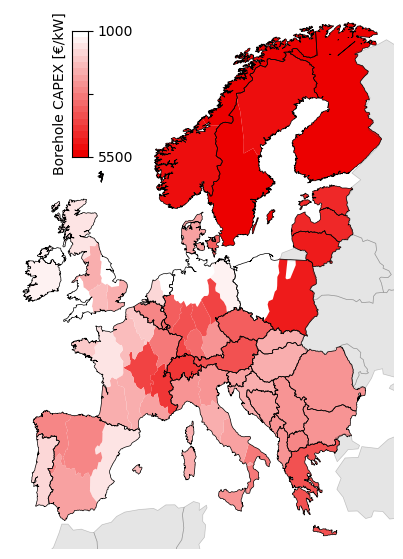

In [262]:
from pyproj import CRS

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap.index = worldmap.name

other_countries = ["Russia", "Ukraine", "Moldova", "Belarus", "Morocco", "Algeria", "Libya", "Egypt", "Tunisia", "Turkey"]

regions = gpd.read_file(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "resources" /
    "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326")

# group regions to countries
regions["country"] = regions["name"].apply(lambda x: x[:2])
countries = regions.dissolve(by="country")

col = 0.1

cmap_kwargs = {
    "elec": dict(factor=1.5, asymetric=False),
    "dh": dict(factor=3, asymetric=True),
    "chp": dict(factor=3, asymetric=True),
}

regions = regions.set_index("name")
regions["name"] = regions.index

regions[col] = data[col]

fig, ax = plt.subplots(1, 1, figsize=(8, 7))
# ax.set_facecolor(adjust_lightness("brown", amount=1, asymetric=True))

vmin = regions[col].min()
vmax = regions[col].max()
cmap = get_cm(color, **cmap_kwargs[app])

regions.plot(
    ax=ax,
    column=col,
    label=f"{int(100*col)}%",
    cmap=cmap,
    )
worldmap.loc[other_countries].plot(
    ax=ax,
    color="grey",
    edgecolor="black",
    alpha=0.2,
    linewidth=0.5,
    )
countries.plot(
    ax=ax,
    color="none",
    edgecolor="black",
    linewidth=0.5,
    )

cax = fig.add_axes([0.35, 0.67, 0.02, 0.18])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cax.set_xticks([])

y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
y = np.hstack((y, y))

cax.imshow(y, aspect='auto', cmap=cmap)# , vmin=vmin, vmax=vmax)
cax.set_ylabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))

cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))
if app == "elec":
    cax.set_yticklabels(["250", "", "1500"])
if app == "dh":
    cax.set_yticklabels(["1000", "", "5500"])
else:
    print(cax.get_yticklabels())
    print(regions[col].min())
    print(regions[col].max())

cax.yaxis.set_ticks_position("right")

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.set_xlim(-12, 33)
ax.set_ylim(34, 72)

plt.show()

<AxesSubplot:xlabel='location'>

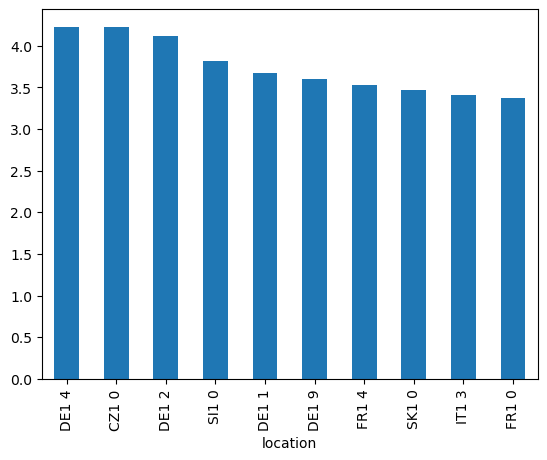

In [56]:

for bus in totals.index.get_level_values(0).unique():
    totals.loc[idx[bus,:],:] = totals.loc[idx[bus,:],:].sum()
